**Code taken from [this notebook](https://www.kaggle.com/thanatoz/one-shot-method-to-tackle-kinship-problem-keras/notebook)**

In [1]:
!pip install keras-vggface
# to remove some utils files that do not exit 
!pip show keras-vggface
!pip install keras_applications
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pyyaml, scipy, six, h5py, numpy, pillow, keras
Required-by: 
     |████████████████████████████████| 50 kB 2.6 MB/s 


20951

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import numpy as np
import pandas as pd
import os
from random import choice, sample
# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# importing library for reading image
from PIL import Image
from glob import glob
import tensorflow as tf
from collections import defaultdict
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D,Flatten, Dense, Dropout, InputLayer,GlobalAvgPool2D, GlobalMaxPool2D, Concatenate, Multiply, Subtract, Add
#from tensorflow.keras.layers.pooling import MaxPool2D
#from tensorflow.keras.layers.convolutional import Convolution2D,Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
 # building a model
from keras import backend as K
K.set_image_data_format('channels_last')
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation
import tensorflow as tf
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import random
from tqdm import tqdm_notebook

In [4]:
!rmdir /root/.kaggle
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

rmdir: failed to remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle competitions download -c recognizing-faces-in-the-wild

  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 30.5MB/s]
  0% 0.00/1.47k [00:00<?, ?B/s]
100% 1.47k/1.47k [00:00<00:00, 1.52MB/s]
  0% 0.00/8.67k [00:00<?, ?B/s]
100% 8.67k/8.67k [00:00<00:00, 7.68MB/s]
  0% 0.00/33.7k [00:00<?, ?B/s]
100% 33.7k/33.7k [00:00<00:00, 28.1MB/s]
  0% 0.00/354k [00:00<?, ?B/s]
100% 354k/354k [00:00<00:00, 40.8MB/s]
 83% 57.0M/68.6M [00:02<00:00, 15.0MB/s]
100% 68.6M/68.6M [00:02<00:00, 25.0MB/s]
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 52.2MB/s]
 33% 9.00M/27.1M [00:01<00:02, 6.45MB/s]
100% 27.1M/27.1M [00:01<00:00, 20.1MB/s]
 50% 17.0M/34.1M [00:01<00:03, 5.70MB/s]
100% 34.1M/34.1M [00:01<00:00, 22.1MB/s]
 99% 129M/130M [00:03<00:00, 47.3MB/s]
100% 130M/130M [00:03<00:00, 41.6MB/s]
 84% 25.0M/29.7M [00:01<00:00, 4.99MB/s]
100% 29.7M/29.7M [00:01<00:00, 19.3MB/s]
 94% 105M/111M [00:03<00:00, 24.7MB/s] 
100% 111M/111M [00:03<00:00, 30.5MB/s]


In [6]:
import os
!mkdir face
!unzip 'train.zip' -d '/content/face/train'
!unzip 'test.zip' -d '/content/face/test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/face/test/face04688.jpg  
  inflating: /content/face/test/face03972.jpg  
  inflating: /content/face/test/face02593.jpg  
  inflating: /content/face/test/face00836.jpg  
  inflating: /content/face/test/face05284.jpg  
  inflating: /content/face/test/face03261.jpg  
  inflating: /content/face/test/face00582.jpg  
  inflating: /content/face/test/face02696.jpg  
  inflating: /content/face/test/face05325.jpg  
  inflating: /content/face/test/face04973.jpg  
  inflating: /content/face/test/face02902.jpg  
  inflating: /content/face/test/face06245.jpg  
  inflating: /content/face/test/face00645.jpg  
  inflating: /content/face/test/face03284.jpg  
  inflating: /content/face/test/face00188.jpg  
  inflating: /content/face/test/face05490.jpg  
  inflating: /content/face/test/face01683.jpg  
  inflating: /content/face/test/face05566.jpg  
  inflating: /content/face/test/face03288.jpg  
  inflating: /content/face/test/face0

### Reading the dataset

In [7]:
train  = pd.read_csv('/content/train_relationships.csv')
train.tail()

,p1,p2
3593,F1000/MID5,F1000/MID8
3594,F1000/MID5,F1000/MID9
3595,F1000/MID6,F1000/MID9
3596,F1000/MID7,F1000/MID8
3597,F1000/MID7,F1000/MID9


In [8]:
TRAIN_BASE = '/content/face/train/'
families = sorted(os.listdir(TRAIN_BASE))
print('We have {} families in the dataset'.format(len(families)))
print(families[:5])

We have 470 families in the dataset
['F0002', 'F0005', 'F0009', 'F0010', 'F0016']


In [9]:
members = {i:sorted(os.listdir(TRAIN_BASE+i)) for i in families}

In [10]:
TEST_BASE='/content/face/test/'
test_images_names = os.listdir(TEST_BASE)
test_images_names[:5]

['face01953.jpg',
 'face01965.jpg',
 'face03512.jpg',
 'face03593.jpg',
 'face05126.jpg']

### Visualizing the dataset

In [11]:
def load_img(PATH):
  return np.array(Image.open(PATH))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

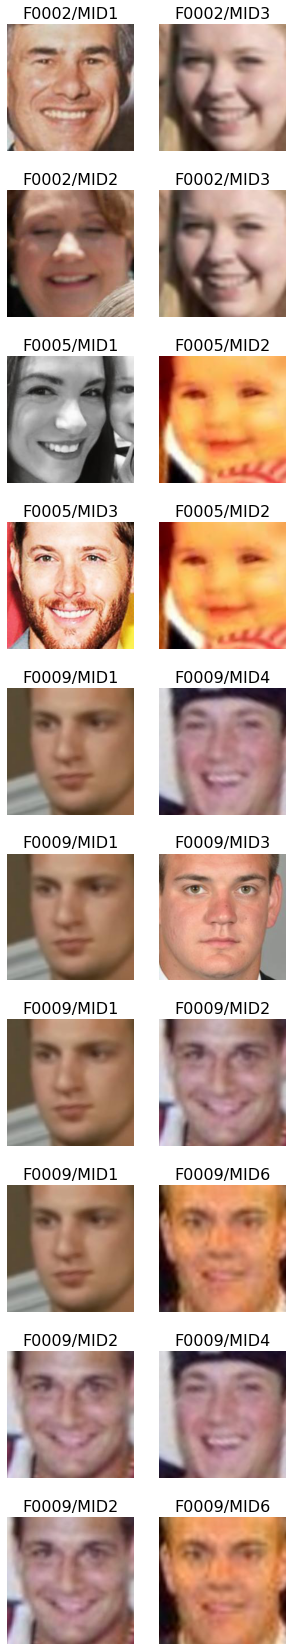

In [12]:
def plot_relations(df, BASE='/content/face/train', rows=1, titles=None):
    tdf = df[:rows]
    tdf1 = tdf.p1
    tdf2 = tdf.p2
    figsize=(5,3*rows)
    f = plt.figure(figsize=figsize)
    x = 0
    for i in range(rows):
        sp = f.add_subplot(rows, 2, x+1)
        sp.axis('Off')
        x+=1
        image_path = os.path.join(BASE,tdf1[i])
        im = os.listdir(image_path)[-1]
        sp.set_title(tdf1[i], fontsize=16)
        plt.imshow(load_img(os.path.join(image_path, im)))
        sp = f.add_subplot(rows, 2, x+1)
        x+=1
        sp.axis('Off')
        image_path = os.path.join(BASE,tdf2[i])
        im = os.listdir(image_path)[-1]
        sp.set_title(tdf2[i], fontsize=16)
        plt.imshow(load_img(os.path.join(image_path, im)))
        
plot_relations(train, rows=10)

In [13]:
test_images = np.array([load_img(os.path.join(TEST_BASE, image)) for image in test_images_names])

In [14]:
test_images.shape

(6282, 224, 224, 3)

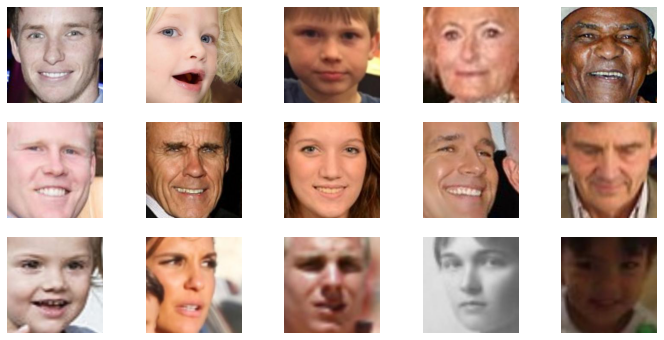

In [15]:
plots(test_images[:15], rows=3)

### Average test faces

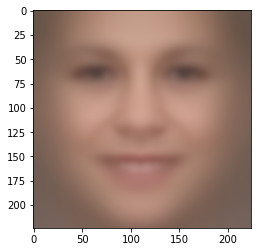

In [16]:
plt.imshow(test_images.sum(axis=0)//test_images.shape[0])

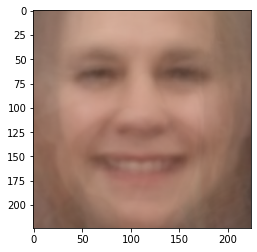

In [17]:
avg_face = []
u = 0
for family in families[u:u+1]:
    for member in os.listdir(os.path.join(TRAIN_BASE,family)):
        for image in os.listdir(os.path.join(TRAIN_BASE, family, member)):
            avg_face.append(load_img(os.path.join(TRAIN_BASE, family, member, image)))
avg_face=np.array(avg_face)
plt.imshow(avg_face.sum(axis=0)//avg_face.shape[0])

## Building the Model

In [18]:
K.set_image_data_format('channels_first')

In [19]:
def vgg_face(weights_path = None):
    img = Input(shape=(3, 224, 224))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    fc6 = Convolution2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
    fc6_drop = Dropout(rate = 0.5)(fc6)
    fc7 = Convolution2D(4096,( 1, 1), activation='relu', name='fc7')(fc6_drop)
    fc7_drop = Dropout(rate = 0.5)(fc7)
    fc8 = Convolution2D(2622, (1, 1), name='fc8')(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(img, out)

    if weights_path:
        model.load_weights(weights_path)

    return model

In [20]:
vgg_facenet = vgg_face()
# '/drive/MyDrive/one_shot_vgg_face_keras.h5'

In [21]:
vgg_facenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 3, 226, 226)      0         
 2D)                                                             
                                                                 
 conv1_1 (Conv2D)            (None, 64, 224, 224)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 64, 226, 226)     0         
 ng2D)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 64, 224, 224)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 112, 112)     0     

In [22]:
im = Image.open('/content/face/train/F0002/MID1/P00009_face3.jpg')
im = np.array(im).astype(np.float32)
im2 = Image.open('/content/face/train/F0002/MID3/P00014_face1.jpg')
im2 = np.array(im2).astype(np.float32)

im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
im2 = im2.transpose((2,0,1))
im2 = np.expand_dims(im2, axis=0)
np.concatenate([im,im2]).shape

(2, 3, 224, 224)

In [ ]:
pip install intel-tensorflow

In [23]:
out = vgg_facenet.predict(np.concatenate([im, im2]))

In [24]:
def cosine_similarity(a,b):
    return np.sum(np.multiply(a,b))/np.multiply( np.sqrt(np.sum(np.power(a,2))),(np.sqrt(np.sum(np.power(b,2)))))

def distance(x, y):
    return np.linalg.norm(x - y)

In [25]:
print(cosine_similarity(out[0], out[1]), distance(out[0], out[1]))

0.99966776 0.00050526654


In [26]:
test_images = os.listdir(TEST_BASE)
test = np.array([load_img(os.path.join(TEST_BASE, i)) for i in test_images])
test_emb = vgg_facenet.predict(test.transpose(0,3,1,2))
print(test.shape, test_emb.shape)

(6282, 224, 224, 3) (6282, 2622)


In [27]:
image_mapping = {img:idx for idx, img in enumerate(test_images)}

In [28]:
submission = pd.read_csv('/content/sample_submission.csv')
req_mapping = [i.split('-') for i in submission.img_pair]

In [29]:
vector_distances=[]
for i in req_mapping:
    a = i[0]
    b = i[1]
    dis = distance(test_emb[image_mapping[a]], test_emb[image_mapping[b]])
    vector_distances.append(dis)
vector_distances=np.array(vector_distances)

In [30]:
total_sum = vector_distances.sum()

In [31]:
probs = []
for dist in vector_distances:
    prob = np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum
    probs.append(1 - prob)

In [32]:
vector_distances.shape

(5310,)

In [33]:
np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum

0.58782077

In [34]:
submission.is_related = probs

In [35]:
submission.to_csv('submission.csv', index=False)

In [36]:
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.967698
1,face05750.jpg-face00898.jpg,0.299542
2,face05820.jpg-face03938.jpg,0.987092
3,face02104.jpg-face01172.jpg,0.991938
4,face02428.jpg-face05611.jpg,0.635240


In [37]:
test_emb.shape

(6282, 2622)

In [38]:
import sklearn.manifold

In [39]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_emb_matrix_2d = tsne.fit_transform(test_emb)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [40]:
points = pd.DataFrame(
    [
        (name, coords[0], coords[1])
        for name, coords in [
            (img, all_emb_matrix_2d[image_mapping[img]])
            for img in test_images
        ]
    ],
    columns=["name", "x", "y"]
)

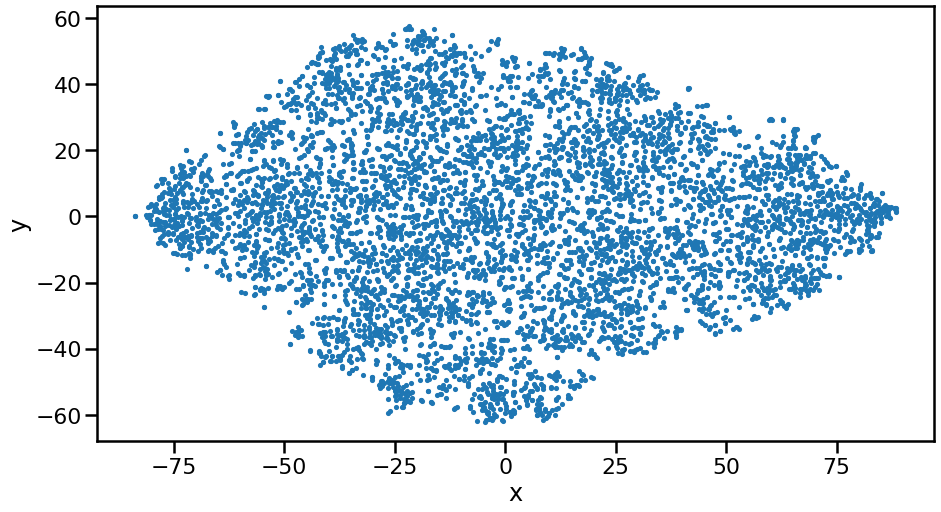

In [41]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(15, 8))

In [42]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

AttributeError: ignored

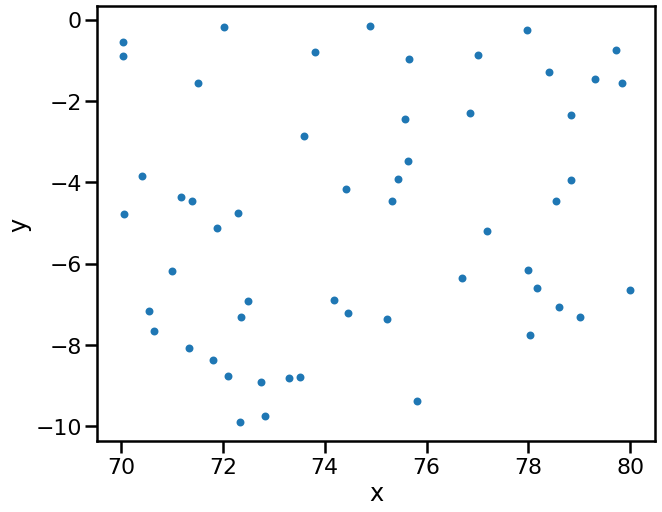

In [43]:
plot_region(x_bounds=(70.0, 80.0), y_bounds=(-10.0, 0.0))

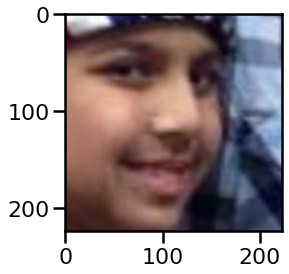

In [44]:
plt.imshow(test[image_mapping['face'+'03198'+'.jpg']])

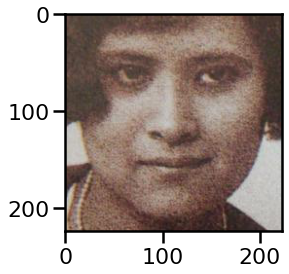

In [45]:
plt.imshow(test[image_mapping['face'+'05866'+'.jpg']])